## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
# Add additional as required


# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns

### Set Directory paths

In [2]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

In [3]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [4]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [5]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [6]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split into Training and ValidationSet

In [7]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Modelling

TODO: ADD Required Models Here. Below is an example of a pipeline set up by Roger with basic hyperparameter tuning.

In [8]:
pipe = Pipeline([ ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', RandomForestClassifier(oob_score = True))
])

param_dist = {
    'pca__n_components': stats.randint(1, X_train.shape[1]),
    'classifier__n_estimators': stats.randint(150, 1500),
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__max_features': ["auto",'sqrt','log2'],
    'classifier__class_weight': ['balanced','balanced_subsample']
}

cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    random_state=1,
    n_iter=1,
    cv=2,
    n_jobs=7,
    verbose=10
)

cv.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              RandomForestClassifier(oob_score=True))]),
                   n_iter=1, n_jobs=7,
                   param_distributions={'classifier__class_weight': ['balanced',
                                                                     'balanced_subsample'],
                                        'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  8, 9],
                                        'classifier__max_features': ['auto',
                                                                     'sqrt',
                                                                     'log2'],
                                        'classifier__n_estimators': <scipy.stats._distn_infr

### Inspect Results

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[145 118]
 [350 987]]
Accuracy:  0.7075
AUC:  0.7043377859176239
              precision    recall  f1-score   support

           0       0.29      0.55      0.38       263
           1       0.89      0.74      0.81      1337

    accuracy                           0.71      1600
   macro avg       0.59      0.64      0.60      1600
weighted avg       0.79      0.71      0.74      1600



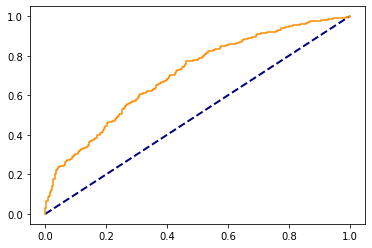

In [9]:
visualize.classification_reports(cv,X_val,y_val)

## Submit Predictions

In [10]:
submit_predictions.submit_predictions(cv, X_test, test_id,"Template TEST")

Success! User is Authenticated


100%|██████████| 24.9k/24.9k [00:07<00:00, 3.33kB/s]


,id,TARGET_5Yrs
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
3794,3794,1
3795,3795,1
3796,3796,0
3797,3797,1
